## **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Final Project: Quora Question Pair - BERT part**

In this notebook, our team construct two BERT models (tiny and base) using PyTorch and apply them on the Quora Question Pair kaggle competition. We optimize both models in various ways to get the best results (loss, accuracy, F1-score). Finally, we evaluate the best models on various samples to confirm they perform well in most cases and also identify the gap for further improvement and future work.

Main references are the text book (Speech and Language Processing) and the BERT paper (https://arxiv.org/pdf/1810.04805.pdf).

In [ ]:
#Ensure the quora-question-pairs folder is at current path,
# and train.csv.zip, test.csv are in the folder.

#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/MyDrive/CS6120/

# Install the transformer library.
#!pip install transformers

Mounted at /content/drive
/content/drive/MyDrive/CS6120
     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 6.5 MB 57.4 MB/s 
     |████████████████████████████████| 895 kB 61.2 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 16.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Load Libraries

In [ ]:
import numpy as np
import pandas as pd

#print & plot tools
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#pytorch library
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import transformers
from transformers import BertTokenizer, BertModel, AdamW

from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')
transformers.logging.set_verbosity_error()

In [ ]:
#seed reproducible result
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Check

Let's take a look at the data and clean it by dropping null rows and resetting the indexes.  
'question1', 'question2' and 'is_duplicate' are the main columns we will use for trainning.

In [ ]:
#train and validation data frame
train_df = pd.read_csv("quora-question-pairs/train.csv.zip", nrows=404286)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404286 entries, 0 to 404285
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404286 non-null  int64 
 1   qid1          404286 non-null  int64 
 2   qid2          404286 non-null  int64 
 3   question1     404285 non-null  object
 4   question2     404284 non-null  object
 5   is_duplicate  404286 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
#drop rows with null
train_df.dropna(inplace=True)
train_df.reset_index(drop=True,inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404283 entries, 0 to 404282
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404283 non-null  int64 
 1   qid1          404283 non-null  int64 
 2   qid2          404283 non-null  int64 
 3   question1     404283 non-null  object
 4   question2     404283 non-null  object
 5   is_duplicate  404283 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
#test data frame
test_df = pd.read_csv("./quora-question-pairs/test.csv")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   test_id    int64 
 1   question1  object
 2   question2  object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [ ]:
test_df.head()
# There is no true label ('is_duplicate' column) in test dataset.

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Data Loaders

## Model Configuration

In [ ]:
# BERT VERSIONS: 
# https://github.com/google-research/bert#fine-tuning-with-bert
# The base model has 12 layers and the inner dimension is 768,
# the tiny model has 2  layers and the inner dimension is 128.
# We select the same max-question-length and batch-size for 
#  better comparision in terms of scores and time consumption.

#base model, run with GPU
BERT_VERSION = 'bert-base-uncased'
OUTPUT_DIM = 768
MAX_Q_LEN = 40
BS = 128

#tiny model, run with CPU
BERT_VERSION = 'prajjwal1/bert-tiny'
OUTPUT_DIM = 128
MAX_Q_LEN = 40
BS = 128

## Model Overview

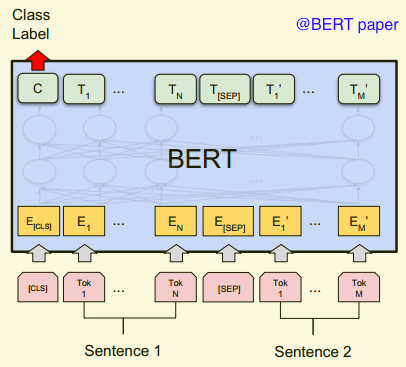

## Input Dataset

As shown above,  
1) The 'question1' and 'question2' sentences will be separating by a [SEP] token.  
2) There is an additional heading [CLS] token, which will be transformed to token C in the output layer.  
3) We will use the output token C to calculate the similarity between the two questions, and compare it with the true 'is_duplicate' label.

In [ ]:
class QQPDataset(Dataset):
    def __init__(self, question1, question2, is_duplicate, tokenizer):
        self.question1 = question1
        self.question2 = question2
        self.is_duplicate = is_duplicate
        self.tokenizer = tokenizer
        self.length = len(question1)
        
    def __len__(self):
        return self.length
        
    def __getitem__(self, idx):
        #[CLS] question1 [SEP] questions2 [SEP] [PAD]*
        inputs = self.tokenizer.encode_plus(
            str(self.question1[idx]),
            str(self.question2[idx]),
            add_special_tokens=True,
            max_length=2*MAX_Q_LEN+3,
            padding='max_length',
            truncation=True
        )
        
        #Test data has no is_duplicate column.
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.is_duplicate[idx]), dtype=torch.long) if self.is_duplicate is not None else 0
        }
        
# Here's a question pair example and its output.
# Input: 'question 1','question 2'
# Output:
#              [CLS] question 1 [SEP] question 2 [SEP]
# 'input_ids': [101, 3160, 1015, 102, 3160, 1016, 102]
# 'token_type_ids': [0, 0, 0, 0, 1, 1, 1] #First 4 tokens belongs to question 1, next 3 tokens belongs to question 2.
# 'attention_mask': [1, 1, 1, 1, 1, 1, 1] #All 7 tokens is needed (at the beginning of training).

In [ ]:
#split data to train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

#get BERT tokenizer 
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# creates datasets
train_data = QQPDataset(
                question1=train_df["question1"].values,
                question2=train_df["question2"].values,
                is_duplicate=train_df["is_duplicate"].values,
                tokenizer=tokenizer
                )

val_data = QQPDataset(
                question1=val_df["question1"].values,
                question2=val_df["question2"].values,
                is_duplicate=val_df["is_duplicate"].values,
                tokenizer=tokenizer
                )
    
test_data = QQPDataset(
                question1=test_df["question1"].values,
                question2=test_df["question2"].values,
                is_duplicate=None,
                tokenizer=tokenizer
                )

# create data loaders
train_dataloader = DataLoader(train_data, batch_size=BS, shuffle=True)
val_dataloader   = DataLoader(val_data,   batch_size=BS, shuffle=True)
test_dataloader  = DataLoader(test_data,  batch_size=BS, shuffle=True)

# BERT Model

In [ ]:
class QQPBertModel(nn.Module):
    def __init__(self, version):
        super().__init__()
        self.bert = BertModel.from_pretrained(version, return_dict=False)
        self.classifier = nn.Linear(OUTPUT_DIM, 1)

    def forward(self, ids, mask, token_type_ids):
        _,cls_out = self.bert(ids,attention_mask=mask,token_type_ids=token_type_ids)
        return self.classifier(cls_out) #Use the heading [CLS] token for classification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QQPBertModel(BERT_VERSION).to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

## Optimizer & Criterion

In [ ]:
#optimizer to train the model
optimizer = AdamW(model.parameters(), lr=0.0001)

#criterion: binary cross entropy loss
def criterion(outputs, targets):
    return nn.BCELoss()(nn.Sigmoid()(torch.squeeze(outputs)), targets)

## Evaluation Function (Accuracy & F1-score)

In [ ]:
#compute validation accuracy
def validation_accuracy(dataloader):
    #move to eval mode
    model.eval()
    
    preds = np.array([],dtype=int)
    labels = np.array([],dtype=int)
    
    with torch.no_grad():
        for batch in dataloader:
            #inputs
            ids = batch["ids"].to(device)
            mask = batch["mask"].to(device)
            token_type_ids = batch["token_type_ids"].to(device)
            
            #forward inputs
            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            
            #predictions
            predict = nn.Sigmoid()(torch.squeeze(outputs)).cpu().numpy()
            preds = np.concatenate([preds, np.where(predict<0.5, 0, 1)])
            
            #true labels
            labels = np.concatenate([labels, batch["targets"].numpy()])
    
    #back to train mode
    model.train()
    
    #calculate accuracy and f1
    return accuracy_score(labels,preds), f1_score(labels,preds)

# Training

Every 100 iterations, the training model will be evaluated in the validation dataset,  
and the resulting accuracy and F1-score will be collected for later visualization,  
model comparision & optimization, problem identification (overfitting, etc).

In [ ]:
EPOCHS = 1
it = 1
total_loss = 0

# 28 Scores over every 100 iterations
f1s = list()       # F1-scores on val dataset
losses = list()    # Losses on train dataset
accuracis = list() # Accuracies on val dataset

for epoch in range(EPOCHS):
    for batch in train_dataloader:
        #inputs and targets
        ids = batch["ids"].to(device)
        mask = batch["mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        targets = batch["targets"].to(device, dtype=torch.float)

        #zero gradients
        optimizer.zero_grad()

        #feed inputs to the model
        outputs = model(ids, mask=mask, token_type_ids=token_type_ids)
        
        #calculate loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        #calculate gradients
        loss.backward()

        #updates weights
        optimizer.step()

        # print loss and accuracy
        if it % 100 == 0:
            acc,f1 = validation_accuracy(val_dataloader)
            print('| Iter', it, '| Avg Train Loss', total_loss/100, '| Val Acc', acc, '| Val F1', f1)
            losses.append(total_loss/100)
            accuracis.append(acc)
            f1s.append(f1)
            total_loss = 0
        it += 1
        

| Iter 100 | Avg Train Loss 0.548946308195591 | Val Acc 0.7450345049345767 | Val F1 0.6793779160186625
| Iter 200 | Avg Train Loss 0.5027375707030296 | Val Acc 0.732444532390116 | Val F1 0.7100854975744418
| Iter 300 | Avg Train Loss 0.4797262960672379 | Val Acc 0.7680625293724801 | Val F1 0.7246027783488501
| Iter 400 | Avg Train Loss 0.4770987990498543 | Val Acc 0.7361300056889857 | Val F1 0.7213748432929378
| Iter 500 | Avg Train Loss 0.4617584630846977 | Val Acc 0.7747903732469267 | Val F1 0.7385649065380309
| Iter 600 | Avg Train Loss 0.4482984048128128 | Val Acc 0.7821860545647926 | Val F1 0.7428905109489051
| Iter 700 | Avg Train Loss 0.44932966828346255 | Val Acc 0.7634618714289247 | Val F1 0.7405799853511651
| Iter 800 | Avg Train Loss 0.4289396646618843 | Val Acc 0.7934403522224146 | Val F1 0.7498727049450385
| Iter 900 | Avg Train Loss 0.43079906910657884 | Val Acc 0.790991614929877 | Val F1 0.7537161177499271
| Iter 1000 | Avg Train Loss 0.4303719148039818 | Val Acc 0.78381

In [ ]:
#save the model
torch.save(model.state_dict(), "bert_qqp_model")

# Results (Loss, Accuracy, F1-score)

We tried different combinations of configurations and training parameters. The following two sets of best results of the final tiny model and the final base model, can be obtained by running twice the above code after choosing one set of configuration. (Remember to save each model with a different file name.)

In [ ]:
# Each has 28 values from 28x100 iterations.
print(f1s)
print(losses)
print(accuracis)

[0.6793779160186625, 0.7100854975744418, 0.7246027783488501, 0.7213748432929378, 0.7385649065380309, 0.7428905109489051, 0.7405799853511651, 0.7498727049450385, 0.7537161177499271, 0.7537195671776374, 0.7458175930922827, 0.7592408177611153, 0.7652783409604356, 0.7625891139526988, 0.7684058320279551, 0.76905680071907, 0.7717602124548683, 0.769156434743065, 0.7746673324912611, 0.7705635034848612, 0.7782114871012239, 0.7792562670785316, 0.7821056457475163, 0.7772800367562601, 0.7820352878274818, 0.782367050839525, 0.7828564644425976, 0.7849120709724101]
[0.548946308195591, 0.5027375707030296, 0.4797262960672379, 0.4770987990498543, 0.4617584630846977, 0.4482984048128128, 0.44932966828346255, 0.4289396646618843, 0.43079906910657884, 0.4303719148039818, 0.43033301442861555, 0.4193442469835281, 0.4161108613014221, 0.4113421955704689, 0.4127776947617531, 0.41370765179395674, 0.4092918437719345, 0.40596951633691786, 0.4006824037432671, 0.40033916115760804, 0.4035826426744461, 0.403639178574085

In [ ]:
#result of tiny model
f1s_tiny=[0.6793779160186625, 0.7100854975744418, 0.7246027783488501, 0.7213748432929378, 0.7385649065380309, 0.7428905109489051, 0.7405799853511651, 0.7498727049450385, 0.7537161177499271, 0.7537195671776374, 0.7458175930922827, 0.7592408177611153, 0.7652783409604356, 0.7625891139526988, 0.7684058320279551, 0.76905680071907, 0.7717602124548683, 0.769156434743065, 0.7746673324912611, 0.7705635034848612, 0.7782114871012239, 0.7792562670785316, 0.7821056457475163, 0.7772800367562601, 0.7820352878274818, 0.782367050839525, 0.7828564644425976, 0.7849120709724101]
losses_tiny=[0.548946308195591, 0.5027375707030296, 0.4797262960672379, 0.4770987990498543, 0.4617584630846977, 0.4482984048128128, 0.44932966828346255, 0.4289396646618843, 0.43079906910657884, 0.4303719148039818, 0.43033301442861555, 0.4193442469835281, 0.4161108613014221, 0.4113421955704689, 0.4127776947617531, 0.41370765179395674, 0.4092918437719345, 0.40596951633691786, 0.4006824037432671, 0.40033916115760804, 0.4035826426744461, 0.4036391785740852, 0.4021053811907768, 0.39976012259721755, 0.3975593909621239, 0.39834764212369916, 0.39454268038272855, 0.39049262523651124]
accuracis_tiny=[0.7450345049345767, 0.732444532390116, 0.7680625293724801, 0.7361300056889857, 0.7747903732469267, 0.7821860545647926, 0.7634618714289247, 0.7934403522224146, 0.790991614929877, 0.7838185460931509, 0.7669989364070345, 0.7966806005590047, 0.7995498280936951, 0.7924262286972223, 0.809839471666378, 0.8029879541912983, 0.8108041257513171, 0.7991046031314155, 0.810259961908531, 0.7988819906502758, 0.8130797200029681, 0.8161715600187984, 0.8220584234089391, 0.8081575106977664, 0.8184966237107028, 0.8159736822577852, 0.8190407875534889, 0.8308887184941502]

In [ ]:
#result of base model
f1s_base=[0.7228456178951228, 0.7988332986100777, 0.8052747252747253, 0.8116038017021558, 0.8213209733487832, 0.8185204168802322, 0.8248115705846404, 0.8252666119770304, 0.8325244209620938, 0.8373507919187912, 0.8400912646675358, 0.8423189713512294, 0.8287006664134525, 0.8468328141225338, 0.8497193668411427, 0.8486807387862797, 0.8489919620503361, 0.8510778997487104, 0.8548646389299722, 0.8545899710642628, 0.8533738562514145, 0.8566837013467039, 0.8567342693707749, 0.860512558969782, 0.8546424901382306, 0.8401171807685679, 0.8558684681751587, 0.8539442694154712]
losses_base=[0.4703619822859764, 0.3833513030409813, 0.35814577966928485, 0.33637426227331163, 0.3300749798119068, 0.32637987166643145, 0.3191591118276119, 0.3135223612189293, 0.29666864827275274, 0.3010682016611099, 0.2972567047178745, 0.29059752836823466, 0.28696021929383275, 0.28561665296554567, 0.28788298353552816, 0.28155293837189677, 0.27767295598983766, 0.2838084550201893, 0.2748081088066101, 0.2775824174284935, 0.2671863394975662, 0.28083142325282096, 0.27352296203374865, 0.2789827859401703, 0.2635282936692238, 0.2745943389832973, 0.25971494674682616, 0.2653802208602428]
accuracis_base=[0.8130549852828415, 0.8328180266640283, 0.8465952657745678, 0.859284177199535, 0.8665067154765144, 0.8686339014074056, 0.8723688441465285, 0.8682876153256326, 0.8651463058695491, 0.8783299116970491, 0.8786514630586955, 0.8789730144203418, 0.8772910534517302, 0.8832521210022508, 0.8821143238764253, 0.8865171040589676, 0.8866160429394742, 0.8885948205496055, 0.8883474733483391, 0.8868881248608672, 0.8878280442256796, 0.8897078829553043, 0.8909693536817631, 0.8917608647258156, 0.8915382522446759, 0.8852556333325089, 0.8904993939993568, 0.8818917113952855]

## Last Accuracy & F1-score

In [ ]:
# Use the last results as the final results.
print('BERT-Tiny Last Accuracy:', accuracis_tiny[-1])
print('BERT-Base Last Accuracy:', accuracis_base[-1])
print()
print('BERT-Tiny Last F1-score:', f1s_tiny[-1])
print('BERT-Base Last F1-score:', f1s_base[-1])

BERT-Tiny Last Accuracy: 0.8308887184941502
BERT-Base Last Accuracy: 0.8818917113952855

BERT-Tiny Last F1-score: 0.7849120709724101
BERT-Base Last F1-score: 0.8539442694154712


## Loss Curve

The base BERT model shows its deeper potential of modeling the data, while the tiny BERT model saturates after 1500 iterations.

Text(0.5, 0, 'Iteration(x100)')

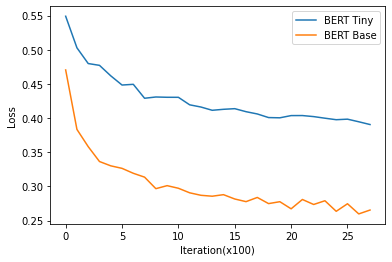

In [ ]:
plt.plot(losses_tiny, label='BERT Tiny')
plt.plot(losses_base, label='BERT Base')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration(x100)')

## Accuracy Curve

We can see that  
1) With only several iterations of training, the tiny model can achieve an accuracy of 70%, and the base model can achieve one of 80%. This shows that BERT can be fine-tuned for a particular task.  
2) The tiny BERT model is less stable than the base BERT model. Its accuracy is going up and down while that of the base model is basically going up all the time. Nonetheless, the tiny model is still attractive because of its efficiency, acceptable accuracy, and light weight.

Text(0.5, 0, 'Iteration(x100)')

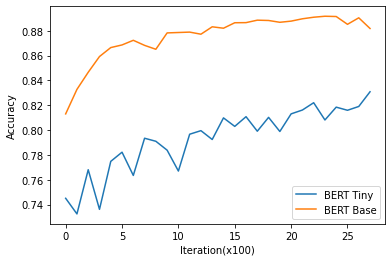

In [ ]:
plt.plot(accuracis_tiny, label='BERT Tiny')
plt.plot(accuracis_base, label='BERT Base')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Iteration(x100)')

## F1-score Curve

Text(0.5, 0, 'Iteration(x100)')

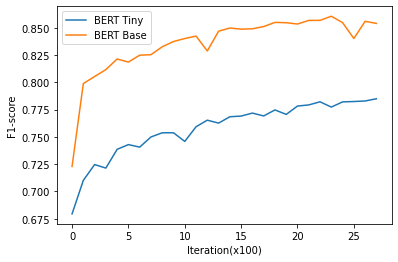

In [ ]:
plt.plot(f1s_tiny, label='BERT Tiny')
plt.plot(f1s_base, label='BERT Base')
plt.legend()
plt.ylabel('F1-score')
plt.xlabel('Iteration(x100)')

# Testing

We evaluate the is_duplicate values on test dataset for submitting to kaggle.

In [ ]:
#predict on test question pairs
predicts = torch.empty(0).to(device)

model.eval()
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        #inputs and targets
        ids = batch["ids"].to(device)
        mask = batch["mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        
        #forward and predict
        outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        predicts = torch.cat((predicts, nn.Sigmoid()(outputs) ))


100%|██████████| 18327/18327 [2:13:34<00:00,  2.29it/s]


In [ ]:
#write results to csv
test_df['is_duplicate'] = predicts.cpu().numpy().squeeze()
test_df[['test_id', 'is_duplicate']].to_csv('submission.csv', index=False)

# Test on samples

Besides of the statistical results above, we evaluate our models on various discrete samples to show how they perform. We found that for a question pair of normal length (about 15 or more words each), both two models get expected results. However, for a very short one (about 5~10 words each), the results are not stable, but the result of base model is much better than that of the tiny model.

In [ ]:
#test a sample question pair
def test_bert(question1, question2):
    inputs = tokenizer.encode_plus(
        question1, question2,
        add_special_tokens=True,
        max_length=2*MAX_Q_LEN+3,
        padding='max_length',
        truncation=True
    )

    ids = torch.tensor([inputs["input_ids"]], dtype=torch.long).to(device)
    mask = torch.tensor([inputs["attention_mask"]], dtype=torch.long).to(device)
    token_type_ids = torch.tensor([inputs["token_type_ids"]], dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
    
    return nn.Sigmoid()(output).item()

In [ ]:
#a question pair from test set
question1 = "How do I quit smoking?"
question2 = "How do I give up on cigarette smoking?"

print('BERT Tiny Score:', test_bert(question1, question2))

BERT Tiny Score: 0.593005895614624


In [ ]:
#compare with BERT base trained on Research Computing
#(change BERT version and create a new tokenizer/model)
model.load_state_dict(torch.load('bert_qqp_model_base', map_location=device))

print('BERT Base Score:', test_bert(question1, question2))

BERT Base Score: 0.7484079003334045
